##Clone resources, import packages, set filepaths

In [1]:
# If you have not already cloned the following repository, do so now
!git clone https://github.com/ZanePeycke/dvu.git

Cloning into 'dvu'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 37 (delta 13), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [2]:
import os
import numpy as np
import cv2
from PIL import Image
from cv2 import resize
import requests
from io import BytesIO
import matplotlib.pyplot as plt

from dvu.scene_recognition.vgg16_places_365 import VGG16_Places365


Using TensorFlow backend.


In [3]:
# Optional (I'm storing movie data here for now)
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load Model

In [3]:
model = VGG16_Places365(weights='places')

543088640/543085444 [==============================] - 7s 0us/step


## Functions for classification

In [4]:
def load_categories():
  # load the class label
  file_name = 'dvu/scene_recognition/categories_places365.txt'
  classes = list()
  with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
  classes = tuple(classes)
  return classes

In [5]:
def scene_recognition(image, predictions_to_return, classes):
  """ Given an image, number of predictions, and class list
      return top prediction of scene category """
  image = np.array(image, dtype=np.uint8)
  image = resize(image, (224, 224))

  # if block is for handling png format
  if len(image.shape) > 2 and image.shape[2] == 4:
    #convert the image from RGBA2RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
  image = np.expand_dims(image, 0)

  # Predict and generate results
  predictions_to_return = predictions_to_return
  preds = model.predict(image)[0]
  top_preds = np.argsort(preds)[::-1][0:predictions_to_return]

  categories = []
  for i in range(0, predictions_to_return):
    categories.append(classes[top_preds[i]])
  
  return categories

In [6]:
def pull_frame(video_path, timestamp):
  """Given a video path and timestamp return an image """
  vidcap = cv2.VideoCapture(video_path)
  vidcap.set(cv2.CAP_PROP_POS_MSEC, timestamp)
  success, image = vidcap.read()
  return image

## Make Predictions On a Single Image

In [8]:
# Load our predefined categories
classes = load_categories()

# Specify a video file and the timestamp in miliseconds
image = pull_frame('/content/gdrive/My Drive/DVU_Challenge/Movies/Honey-final-180k.mp4', 700000)

# We can return a single scene, or the top n categories
categories = scene_recognition(image, 5, classes)

# Print scene category
if len(categories) == 1:
  print(f'The most likely scene category is: {categories}')
else:
  print(f'The most likely scene categories are: {categories}')

The most likely scene categories are: ['kitchen', 'galley', 'restaurant_kitchen', 'clean_room', 'chemistry_lab']


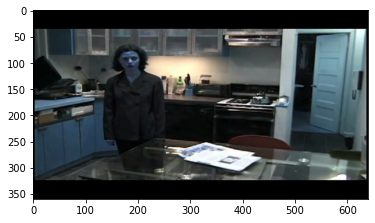

In [9]:
# For reference we can plot the image
plt.imshow(image)
plt.show()

## Make predictions on a full Scene

In [7]:
def full_shot_scene_recognition(start_frame, end_frame, movie_path, classes, frame_incriment):
  i = start_frame
  scene_list = []
  while i < end_frame:
    image = pull_frame(movie_path, i)
    categories = scene_recognition(image, 1, classes)
    scene_list.append(categories)
    i+=frame_incriment

  scene = most_frequent(scene_list)
  return scene


In [8]:
def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

In [15]:
classes = load_categories()

movie_path = '/content/drive/My Drive/DVU_Challenge/Movies/Let’s Bring Back Sophie.mp4'

# Start, end, and incriment are all in ms
start_frame = 6000
end_frame = 7000
frame_incriment=1000


scene = full_shot_scene_recognition(start_frame,end_frame , movie_path, classes, frame_incriment)
print(scene)

['field/wild']
